In [1]:
import os
import sys
import re
from nltk.corpus import stopwords
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars ' + sys.executable + '/lib/spark-nlp-assembly-1.6.0.jar pyspark-shell'

In [2]:
from pyspark.sql import SparkSession, SQLContext
import os
import pyspark.sql.functions as f
spark = SparkSession.builder \
    .master("local[1]") \
    .appName("SparkByExamples.com") \
    .getOrCreate()

22/04/11 09:21:05 WARN Utils: Your hostname, DSGPU05 resolves to a loopback address: 127.0.1.1; using 10.10.11.64 instead (on interface eno1)
22/04/11 09:21:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
22/04/11 09:21:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
22/04/11 09:21:06 WARN DependencyUtils: Local jar /opt/conda/bin/python3.8/lib/spark-nlp-assembly-1.6.0.jar does not exist, skipping.
22/04/11 09:21:06 INFO SparkContext: Running Spark version 3.2.1
22/04/11 09:21:06 INFO ResourceUtils: ==============================================================
22/04/11 09:21:06 INFO ResourceUtils: No custom resources configured for spark.driver.
22/04/11 09:21:06 INFO ResourceUtils: ==============================================================
22/04/11 09:21:06 INFO SparkContext: Submitted application:

In [3]:
sc = SparkSession.builder.appName('App Name').master("local[*]").getOrCreate()
sqlContext = SQLContext(sparkContext=sc.sparkContext, sparkSession=sc)

In [4]:
data = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/classics_raw.csv"))

22/04/11 09:21:09 INFO InMemoryFileIndex: It took 206 ms to list leaf files for 1 paths.
22/04/11 09:21:09 INFO InMemoryFileIndex: It took 1 ms to list leaf files for 1 paths.
22/04/11 09:21:11 INFO FileSourceStrategy: Pushed Filters: 
22/04/11 09:21:11 INFO FileSourceStrategy: Post-Scan Filters: (length(trim(value#0, None)) > 0)
22/04/11 09:21:11 INFO FileSourceStrategy: Output Data Schema: struct<value: string>
22/04/11 09:21:12 INFO CodeGenerator: Code generated in 189.685047 ms
22/04/11 09:21:12 INFO MemoryStore: Block broadcast_0 stored as values in memory (estimated size 339.1 KiB, free 408.6 MiB)
22/04/11 09:21:12 INFO MemoryStore: Block broadcast_0_piece0 stored as bytes in memory (estimated size 32.7 KiB, free 408.5 MiB)
22/04/11 09:21:12 INFO BlockManagerInfo: Added broadcast_0_piece0 in memory on dsgpu05.network.ncf.edu:42845 (size: 32.7 KiB, free: 408.9 MiB)
22/04/11 09:21:12 INFO SparkContext: Created broadcast 0 from load at NativeMethodAccessorImpl.java:0
22/04/11 09:21:

In [5]:
import nltk
nltk.pos_tag(["Arthur", "loves", "fish"])

22/04/11 09:21:13 INFO BlockManagerInfo: Removed broadcast_1_piece0 on dsgpu05.network.ncf.edu:42845 in memory (size: 5.8 KiB, free: 408.8 MiB)


[('Arthur', 'NNP'), ('loves', 'VBZ'), ('fish', 'JJ')]

In [6]:
import pyspark.sql.functions as f
data = data.withColumn('line', f.explode(f.split(f.col('text'), '\n')))
data.show()

22/04/11 09:21:14 INFO FileSourceStrategy: Pushed Filters: 
22/04/11 09:21:14 INFO FileSourceStrategy: Post-Scan Filters: 
22/04/11 09:21:14 INFO FileSourceStrategy: Output Data Schema: struct<id: string, type: string, text: string ... 1 more fields>
22/04/11 09:21:14 INFO CodeGenerator: Code generated in 20.834396 ms
22/04/11 09:21:14 INFO MemoryStore: Block broadcast_4 stored as values in memory (estimated size 339.0 KiB, free 407.8 MiB)
22/04/11 09:21:14 INFO MemoryStore: Block broadcast_4_piece0 stored as bytes in memory (estimated size 32.6 KiB, free 407.8 MiB)
22/04/11 09:21:14 INFO BlockManagerInfo: Added broadcast_4_piece0 in memory on dsgpu05.network.ncf.edu:42845 (size: 32.6 KiB, free: 408.8 MiB)
22/04/11 09:21:14 INFO SparkContext: Created broadcast 4 from showString at NativeMethodAccessorImpl.java:0
22/04/11 09:21:14 INFO FileSourceScanExec: Planning scan with bin packing, max size: 10675308 bytes, open cost is considered as scanning 4194304 bytes.
22/04/11 09:21:14 INFO S

+--------------------+--------------------+--------------------+--------------------+
|                  id|                type|                text|                line|
+--------------------+--------------------+--------------------+--------------------+
|                1905|                   C|                   "|                   "|
|             reading|             writing|             working|             working|
|knowledge  to ren...|          and gentle|                kind|                kind|
|    This gentlewoman| whose name was T...| was the widow of...| was the widow of...|
|        Mrs. Teachum| though exceeding...|         yet thought|         yet thought|
|             desires| and did not seek...| she was resolved to| she was resolved to|
|would be prevaile...| great applicatio...|            when any|            when any|
|        reprehending| and that pretty ...| any girl that wa...| any girl that wa...|
|dignity and autho...| by her steady be...| that the g

22/04/11 09:21:14 INFO CodeGenerator: Code generated in 16.594267 ms


In [7]:
def removeProperNouns(sentence):
    tagged_sentence = nltk.tag.pos_tag(nltk.word_tokenize(sentence))
    edited_sentence = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS']
    return ' '.join(edited_sentence)

In [8]:
classics = sqlContext.read.format("csv") \
   .options(header='true', inferschema='true') \
   .load(os.path.realpath("data/classics_raw.csv"))
StopWords = nltk.corpus.stopwords.words("english")
classics = data.rdd.map(lambda x : x['line']).filter(lambda x: x is not None)
tokens = classics                                                 \
    .map(lambda document: removeProperNouns(document))             \
    .map( lambda document: document.strip().lower())               \
    .map( lambda document: re.split(" ", document))          \
    .map( lambda word: [x for x in word if x.isalpha()])           \
    .map( lambda word: [x for x in word if len(x) > 3] )           \
    .map( lambda word: [x for x in word if x not in StopWords])     \
    .zipWithIndex()

22/04/11 09:21:14 INFO InMemoryFileIndex: It took 1 ms to list leaf files for 1 paths.
22/04/11 09:21:14 INFO InMemoryFileIndex: It took 1 ms to list leaf files for 1 paths.
22/04/11 09:21:14 INFO FileSourceStrategy: Pushed Filters: 
22/04/11 09:21:14 INFO FileSourceStrategy: Post-Scan Filters: (length(trim(value#48, None)) > 0)
22/04/11 09:21:14 INFO FileSourceStrategy: Output Data Schema: struct<value: string>
22/04/11 09:21:14 INFO MemoryStore: Block broadcast_6 stored as values in memory (estimated size 339.1 KiB, free 407.4 MiB)
22/04/11 09:21:14 INFO MemoryStore: Block broadcast_6_piece0 stored as bytes in memory (estimated size 32.7 KiB, free 407.4 MiB)
22/04/11 09:21:14 INFO BlockManagerInfo: Added broadcast_6_piece0 in memory on dsgpu05.network.ncf.edu:42845 (size: 32.7 KiB, free: 408.8 MiB)
22/04/11 09:21:14 INFO SparkContext: Created broadcast 6 from load at NativeMethodAccessorImpl.java:0
22/04/11 09:21:14 INFO FileSourceScanExec: Planning scan with bin packing, max size: 1

In [9]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, IDF
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

22/04/11 09:21:15 INFO SparkContext: Starting job: runJob at PythonRDD.scala:166
22/04/11 09:21:15 INFO DAGScheduler: Got job 5 (runJob at PythonRDD.scala:166) with 1 output partitions
22/04/11 09:21:15 INFO DAGScheduler: Final stage: ResultStage 5 (runJob at PythonRDD.scala:166)
22/04/11 09:21:15 INFO DAGScheduler: Parents of final stage: List()
22/04/11 09:21:15 INFO DAGScheduler: Missing parents: List()
22/04/11 09:21:15 INFO DAGScheduler: Submitting ResultStage 5 (PythonRDD[30] at RDD at PythonRDD.scala:53), which has no missing parents
22/04/11 09:21:15 INFO MemoryStore: Block broadcast_11 stored as values in memory (estimated size 25.2 KiB, free 406.6 MiB)
22/04/11 09:21:15 INFO MemoryStore: Block broadcast_11_piece0 stored as bytes in memory (estimated size 12.7 KiB, free 406.6 MiB)
22/04/11 09:21:15 INFO BlockManagerInfo: Added broadcast_11_piece0 in memory on dsgpu05.network.ncf.edu:42845 (size: 12.7 KiB, free: 408.7 MiB)
22/04/11 09:21:15 INFO SparkContext: Created broadcast 

In [10]:
from pyspark.sql.functions import udf, col, StringType, column
from pyspark.ml.feature import RegexTokenizer, CountVectorizer
from pyspark.ml.linalg import Vectors, SparseVector
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import CountVectorizer
df_txts = sqlContext.createDataFrame(tokens, ["list_of_words",'index'])# TF
cv = CountVectorizer(inputCol="list_of_words", outputCol="raw_features", vocabSize=5000, minDF=1.0)
cvmodel = cv.fit(df_txts)
result_cv = cvmodel.transform(df_txts)
# IDF
idf = IDF(inputCol="raw_features", outputCol="features")
idfModel = idf.fit(result_cv)
result_tfidf = idfModel.transform(result_cv) 

22/04/11 09:21:32 INFO SparkContext: Starting job: runJob at PythonRDD.scala:166
22/04/11 09:21:32 INFO DAGScheduler: Got job 10 (runJob at PythonRDD.scala:166) with 1 output partitions
22/04/11 09:21:32 INFO DAGScheduler: Final stage: ResultStage 12 (runJob at PythonRDD.scala:166)
22/04/11 09:21:32 INFO DAGScheduler: Parents of final stage: List()
22/04/11 09:21:32 INFO DAGScheduler: Missing parents: List()
22/04/11 09:21:32 INFO DAGScheduler: Submitting ResultStage 12 (PythonRDD[52] at RDD at PythonRDD.scala:53), which has no missing parents
22/04/11 09:21:32 INFO MemoryStore: Block broadcast_18 stored as values in memory (estimated size 25.2 KiB, free 406.9 MiB)
22/04/11 09:21:32 INFO MemoryStore: Block broadcast_18_piece0 stored as bytes in memory (estimated size 12.8 KiB, free 406.9 MiB)
22/04/11 09:21:32 INFO BlockManagerInfo: Added broadcast_18_piece0 in memory on dsgpu05.network.ncf.edu:42845 (size: 12.8 KiB, free: 408.7 MiB)
22/04/11 09:21:32 INFO SparkContext: Created broadca

In [11]:
num_topics = 10
max_iterations = 100
lda = LDA(k=num_topics, maxIter=max_iterations)
lda_model = lda.fit(result_tfidf[['index','features']])

22/04/11 09:21:47 INFO Instrumentation: [c9c96ff7] Stage class: LDA
22/04/11 09:21:47 INFO Instrumentation: [c9c96ff7] Stage uid: LDA_3b4bc6358d5b
22/04/11 09:21:47 INFO CodeGenerator: Code generated in 19.448569 ms
22/04/11 09:21:47 INFO Instrumentation: [c9c96ff7] training: numPartitions=1 storageLevel=StorageLevel(1 replicas)
22/04/11 09:21:47 INFO Instrumentation: [c9c96ff7] {"k":10,"maxIter":100}
22/04/11 09:21:47 INFO CodeGenerator: Code generated in 17.004272 ms
22/04/11 09:21:47 INFO SparkContext: Starting job: count at LDAOptimizer.scala:413
22/04/11 09:21:47 INFO DAGScheduler: Got job 15 (count at LDAOptimizer.scala:413) with 1 output partitions
22/04/11 09:21:47 INFO DAGScheduler: Final stage: ResultStage 19 (count at LDAOptimizer.scala:413)
22/04/11 09:21:47 INFO DAGScheduler: Parents of final stage: List()
22/04/11 09:21:47 INFO DAGScheduler: Missing parents: List()
22/04/11 09:21:47 INFO DAGScheduler: Submitting ResultStage 19 (MapPartitionsRDD[82] at map at LDA.scala:100

In [12]:
data.printSchema()
data.show()

root
 |-- id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- text: string (nullable = true)
 |-- line: string (nullable = true)

+--------------------+--------------------+--------------------+--------------------+
|                  id|                type|                text|                line|
+--------------------+--------------------+--------------------+--------------------+
|                1905|                   C|                   "|                   "|
|             reading|             writing|             working|             working|
|knowledge  to ren...|          and gentle|                kind|                kind|
|    This gentlewoman| whose name was T...| was the widow of...| was the widow of...|
|        Mrs. Teachum| though exceeding...|         yet thought|         yet thought|
|             desires| and did not seek...| she was resolved to| she was resolved to|
|would be prevaile...| great applicatio...|            when any|            wh

22/04/11 09:22:11 INFO FileSourceStrategy: Pushed Filters: 
22/04/11 09:22:11 INFO FileSourceStrategy: Post-Scan Filters: 
22/04/11 09:22:11 INFO FileSourceStrategy: Output Data Schema: struct<id: string, type: string, text: string ... 1 more fields>
22/04/11 09:22:11 INFO MemoryStore: Block broadcast_327 stored as values in memory (estimated size 339.0 KiB, free 404.9 MiB)
22/04/11 09:22:11 INFO MemoryStore: Block broadcast_327_piece0 stored as bytes in memory (estimated size 32.6 KiB, free 404.9 MiB)
22/04/11 09:22:11 INFO BlockManagerInfo: Added broadcast_327_piece0 in memory on dsgpu05.network.ncf.edu:42845 (size: 32.6 KiB, free: 408.6 MiB)
22/04/11 09:22:11 INFO SparkContext: Created broadcast 327 from showString at NativeMethodAccessorImpl.java:0
22/04/11 09:22:11 INFO FileSourceScanExec: Planning scan with bin packing, max size: 10675308 bytes, open cost is considered as scanning 4194304 bytes.
22/04/11 09:22:11 INFO SparkContext: Starting job: showString at NativeMethodAccessor

In [13]:
from pyspark.sql.types import *
vocab = cvmodel.vocabulary
vocab_broadcast = sc.sparkContext.broadcast(vocab)

#creating LDA model
ldatopics = lda_model.describeTopics()

def map_termID_to_Word(termIndices):
    words = []
    for termID in termIndices:
        words.append(vocab_broadcast.value[termID])

    return words

udf_map_termID_to_Word = udf(map_termID_to_Word , ArrayType(StringType()))

ldatopics_mapped = ldatopics.withColumn("topic_desc", udf_map_termID_to_Word(ldatopics.termIndices))

22/04/11 09:22:11 INFO MemoryStore: Block broadcast_329 stored as values in memory (estimated size 312.0 B, free 404.9 MiB)
22/04/11 09:22:11 INFO MemoryStore: Block broadcast_329_piece0 stored as bytes in memory (estimated size 35.3 KiB, free 404.9 MiB)
22/04/11 09:22:11 INFO BlockManagerInfo: Added broadcast_329_piece0 in memory on dsgpu05.network.ncf.edu:42845 (size: 35.3 KiB, free: 408.5 MiB)
22/04/11 09:22:11 INFO SparkContext: Created broadcast 329 from broadcast at NativeMethodAccessorImpl.java:0
/opt/spark/python/lib/pyspark.zip/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.


In [14]:
ldatopics_mapped.show()

22/04/11 09:22:11 INFO CodeGenerator: Code generated in 15.625006 ms
22/04/11 09:22:11 INFO CodeGenerator: Code generated in 7.785819 ms
22/04/11 09:22:11 INFO SparkContext: Starting job: showString at NativeMethodAccessorImpl.java:0
22/04/11 09:22:11 INFO DAGScheduler: Got job 218 (showString at NativeMethodAccessorImpl.java:0) with 1 output partitions
22/04/11 09:22:11 INFO DAGScheduler: Final stage: ResultStage 222 (showString at NativeMethodAccessorImpl.java:0)
22/04/11 09:22:11 INFO DAGScheduler: Parents of final stage: List()
22/04/11 09:22:11 INFO DAGScheduler: Missing parents: List()
22/04/11 09:22:11 INFO DAGScheduler: Submitting ResultStage 222 (MapPartitionsRDD[392] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
22/04/11 09:22:11 INFO MemoryStore: Block broadcast_330 stored as values in memory (estimated size 23.1 KiB, free 404.8 MiB)
22/04/11 09:22:11 INFO MemoryStore: Block broadcast_330_piece0 stored as bytes in memory (estimated size 10.6

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[4, 6, 16, 36, 46...|[0.04519727919629...|[little, never, t...|
|    1|[7, 8, 22, 39, 48...|[0.03768318987126...|[must, think, tel...|
|    2|[9, 10, 21, 17, 2...|[0.03020859995829...|[shall, though, q...|
|    3|[0, 3, 5, 18, 27,...|[0.12222646934808...|[said, like, know...|
|    4|[25, 34, 60, 74, ...|[0.02414741858349...|[dear, time, ever...|
|    5|[2, 13, 19, 32, 2...|[0.05707177743921...|[could, come, mad...|
|    6|[23, 20, 45, 72, ...|[0.02854624233863...|[even, rather, to...|
|    7|[14, 44, 38, 69, ...|[0.02815162694031...|[looking, many, y...|
|    8|[1, 11, 24, 50, 6...|[0.06748219260012...|[would, good, mak...|
|    9|[12, 15, 30, 33, ...|[0.03359040363669...|[much, answered, ...|
+-----+--------------------+--------------------+--------------------+



22/04/11 09:22:12 INFO CodeGenerator: Code generated in 14.599702 ms
22/04/11 09:22:12 INFO PythonUDFRunner: Times: total = 536, boot = 513, init = 21, finish = 2
22/04/11 09:22:12 INFO Executor: Finished task 0.0 in stage 222.0 (TID 220). 4943 bytes result sent to driver
22/04/11 09:22:12 INFO TaskSetManager: Finished task 0.0 in stage 222.0 (TID 220) in 586 ms on dsgpu05.network.ncf.edu (executor driver) (1/1)
22/04/11 09:22:12 INFO TaskSchedulerImpl: Removed TaskSet 222.0, whose tasks have all completed, from pool 
22/04/11 09:22:12 INFO DAGScheduler: ResultStage 222 (showString at NativeMethodAccessorImpl.java:0) finished in 0.592 s
22/04/11 09:22:12 INFO DAGScheduler: Job 218 is finished. Cancelling potential speculative or zombie tasks for this job
22/04/11 09:22:12 INFO TaskSchedulerImpl: Killing all running tasks in stage 222: Stage finished
22/04/11 09:22:12 INFO DAGScheduler: Job 218 finished: showString at NativeMethodAccessorImpl.java:0, took 0.594553 s
22/04/11 09:22:12 IN

In [15]:
from pyspark.sql.functions import concat_ws, split
import pyspark.sql.functions as f
lda_topics_mapped = ldatopics_mapped.withColumn("topic_desc", concat_ws(" ", ldatopics_mapped.topic_desc).alias("topic_desc_str"))

lda_topics_mapped.show()

+-----+--------------------+--------------------+--------------------+
|topic|         termIndices|         termWeights|          topic_desc|
+-----+--------------------+--------------------+--------------------+
|    0|[4, 6, 16, 36, 46...|[0.04519727919629...|little never thou...|
|    1|[7, 8, 22, 39, 48...|[0.03768318987126...|must think tell a...|
|    2|[9, 10, 21, 17, 2...|[0.03020859995829...|shall though quit...|
|    3|[0, 3, 5, 18, 27,...|[0.12222646934808...|said like know aw...|
|    4|[25, 34, 60, 74, ...|[0.02414741858349...|dear time ever wh...|
|    5|[2, 13, 19, 32, 2...|[0.05707177743921...|could come made g...|
|    6|[23, 20, 45, 72, ...|[0.02854624233863...|even rather took ...|
|    7|[14, 44, 38, 69, ...|[0.02815162694031...|looking many youn...|
|    8|[1, 11, 24, 50, 6...|[0.06748219260012...|would good make t...|
|    9|[12, 15, 30, 33, ...|[0.03359040363669...|much answered lov...|
+-----+--------------------+--------------------+--------------------+



22/04/11 09:22:12 INFO CodeGenerator: Code generated in 11.031705 ms
22/04/11 09:22:12 INFO SparkContext: Starting job: showString at NativeMethodAccessorImpl.java:0
22/04/11 09:22:12 INFO DAGScheduler: Got job 219 (showString at NativeMethodAccessorImpl.java:0) with 1 output partitions
22/04/11 09:22:12 INFO DAGScheduler: Final stage: ResultStage 223 (showString at NativeMethodAccessorImpl.java:0)
22/04/11 09:22:12 INFO DAGScheduler: Parents of final stage: List()
22/04/11 09:22:12 INFO DAGScheduler: Missing parents: List()
22/04/11 09:22:12 INFO DAGScheduler: Submitting ResultStage 223 (MapPartitionsRDD[398] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
22/04/11 09:22:12 INFO MemoryStore: Block broadcast_331 stored as values in memory (estimated size 22.9 KiB, free 404.8 MiB)
22/04/11 09:22:12 INFO MemoryStore: Block broadcast_331_piece0 stored as bytes in memory (estimated size 10.7 KiB, free 404.8 MiB)
22/04/11 09:22:12 INFO BlockManagerInfo: Added

In [21]:
counts = lda_topics_mapped.withColumn('word', f.explode(f.split(f.col('topic_desc'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=True)
counts.show()

+--------+-----+
|    word|count|
+--------+-----+
|   still|    1|
|    hope|    1|
|   leave|    1|
|    even|    1|
|  always|    1|
|   could|    1|
|    seen|    1|
|    sure|    1|
|    must|    1|
|    hand|    1|
|answered|    1|
|    back|    1|
|  seemed|    1|
|   girls|    1|
|  rather|    1|
|  looked|    1|
|    love|    1|
|    soon|    1|
|    hear|    1|
|    kind|    1|
+--------+-----+
only showing top 20 rows



22/04/11 09:24:10 INFO DAGScheduler: Registering RDD 432 (showString at NativeMethodAccessorImpl.java:0) as input to shuffle 5
22/04/11 09:24:10 INFO DAGScheduler: Got map stage job 226 (showString at NativeMethodAccessorImpl.java:0) with 1 output partitions
22/04/11 09:24:10 INFO DAGScheduler: Final stage: ShuffleMapStage 235 (showString at NativeMethodAccessorImpl.java:0)
22/04/11 09:24:10 INFO DAGScheduler: Parents of final stage: List()
22/04/11 09:24:10 INFO DAGScheduler: Missing parents: List()
22/04/11 09:24:10 INFO DAGScheduler: Submitting ShuffleMapStage 235 (MapPartitionsRDD[432] at showString at NativeMethodAccessorImpl.java:0), which has no missing parents
22/04/11 09:24:10 INFO MemoryStore: Block broadcast_338 stored as values in memory (estimated size 40.5 KiB, free 406.0 MiB)
22/04/11 09:24:10 INFO MemoryStore: Block broadcast_338_piece0 stored as bytes in memory (estimated size 18.9 KiB, free 405.9 MiB)
22/04/11 09:24:10 INFO BlockManagerInfo: Added broadcast_338_piece0

22/04/11 09:22:13 INFO CodeGenerator: Code generated in 39.112713 ms
22/04/11 09:22:13 INFO CodeGenerator: Code generated in 5.23842 ms
22/04/11 09:22:13 INFO DAGScheduler: Registering RDD 404 (javaToPython at NativeMethodAccessorImpl.java:0) as input to shuffle 2
22/04/11 09:22:13 INFO DAGScheduler: Got map stage job 220 (javaToPython at NativeMethodAccessorImpl.java:0) with 1 output partitions
22/04/11 09:22:13 INFO DAGScheduler: Final stage: ShuffleMapStage 224 (javaToPython at NativeMethodAccessorImpl.java:0)
22/04/11 09:22:13 INFO DAGScheduler: Parents of final stage: List()
22/04/11 09:22:13 INFO DAGScheduler: Missing parents: List()
22/04/11 09:22:13 INFO DAGScheduler: Submitting ShuffleMapStage 224 (MapPartitionsRDD[404] at javaToPython at NativeMethodAccessorImpl.java:0), which has no missing parents
22/04/11 09:22:13 INFO MemoryStore: Block broadcast_332 stored as values in memory (estimated size 40.5 KiB, free 404.7 MiB)
22/04/11 09:22:13 INFO MemoryStore: Block broadcast_33

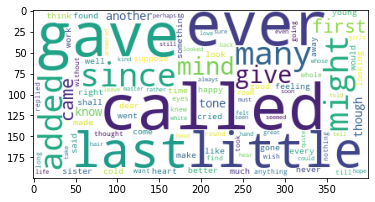

In [17]:
import pyspark.sql.functions as F
from collections import ChainMap
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*counts.select(F.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))
# {'scorbutically': 1.76, 'punta': 1.76, 'detail': 1.789, 'lafayette': 1.8, 'maya': 1.854, 'prostate': 1.854, 'quot': 1.856, 'mark': 1.949, 'elite': 1.988, 'trade': 2.012, 'write': 2.083}

plt.imshow(wordcloud.generate_from_frequencies(words))

plt.show()


In [18]:
nltk.pos_tag(["lisa"])

[('lisa', 'NN')]

In [19]:
removeProperNouns("Lisa is me")

'is me'